In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt  # Visualization
import warnings  # Supress warnings
import os
import random

In [26]:

warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model

In [27]:

# Seed value
SEED = 2023
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(SEED)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [108]:
df = pd.read_csv("./files/cycl_data.csv", index_col=0)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry,year,month,day,day_of_year,week_of_year,...,day_sin,day_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos,season_sin,season_cos
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,0.0,0.175907,0.242507,0.672018,0.260870,2009,1,1,1,1,...,2.079117e-01,0.978148,0.017213,0.999852,0.120208,0.992749,1.000000e+00,6.123234e-17,1.0,6.123234e-17
2009-01-02,0.0,0.177960,0.163488,0.507291,0.304348,2009,1,2,2,1,...,4.067366e-01,0.913545,0.034422,0.999407,0.120208,0.992749,1.000000e+00,6.123234e-17,1.0,6.123234e-17
2009-01-03,0.0,0.180698,0.220708,0.624189,0.260870,2009,1,3,3,1,...,5.877853e-01,0.809017,0.051620,0.998667,0.120208,0.992749,1.000000e+00,6.123234e-17,1.0,6.123234e-17
2009-01-04,0.0,0.182067,0.122616,0.540839,0.260870,2009,1,4,4,1,...,7.431448e-01,0.669131,0.068802,0.997630,0.120208,0.992749,1.000000e+00,6.123234e-17,1.0,6.123234e-17
2009-01-05,0.0,0.184805,0.049046,0.465917,0.217391,2009,1,5,5,2,...,8.660254e-01,0.500000,0.085965,0.996298,0.238673,0.971100,1.000000e+00,6.123234e-17,1.0,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.591376,0.801090,0.462974,0.304348,2020,6,26,178,26,...,-7.431448e-01,0.669131,0.077386,-0.997001,0.008610,-0.999963,1.224647e-16,-1.000000e+00,-1.0,-1.836970e-16
2020-06-27,0.0,0.588638,0.814714,0.408690,0.260870,2020,6,27,179,26,...,-5.877853e-01,0.809017,0.060213,-0.998186,0.008610,-0.999963,1.224647e-16,-1.000000e+00,-1.0,-1.836970e-16
2020-06-28,0.0,0.583162,0.833787,0.378186,0.260870,2020,6,28,180,26,...,-4.067366e-01,0.913545,0.043022,-0.999074,0.008610,-0.999963,1.224647e-16,-1.000000e+00,-1.0,-1.836970e-16


In [109]:
features_cos = ['Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry', 'day_cos',
                'month_cos', 'week_of_year_cos', 'quarter_cos', 'season_cos']
delete = [feature for feature in df.columns if feature not in features_cos]
df_cos = df.drop(delete, axis=1)

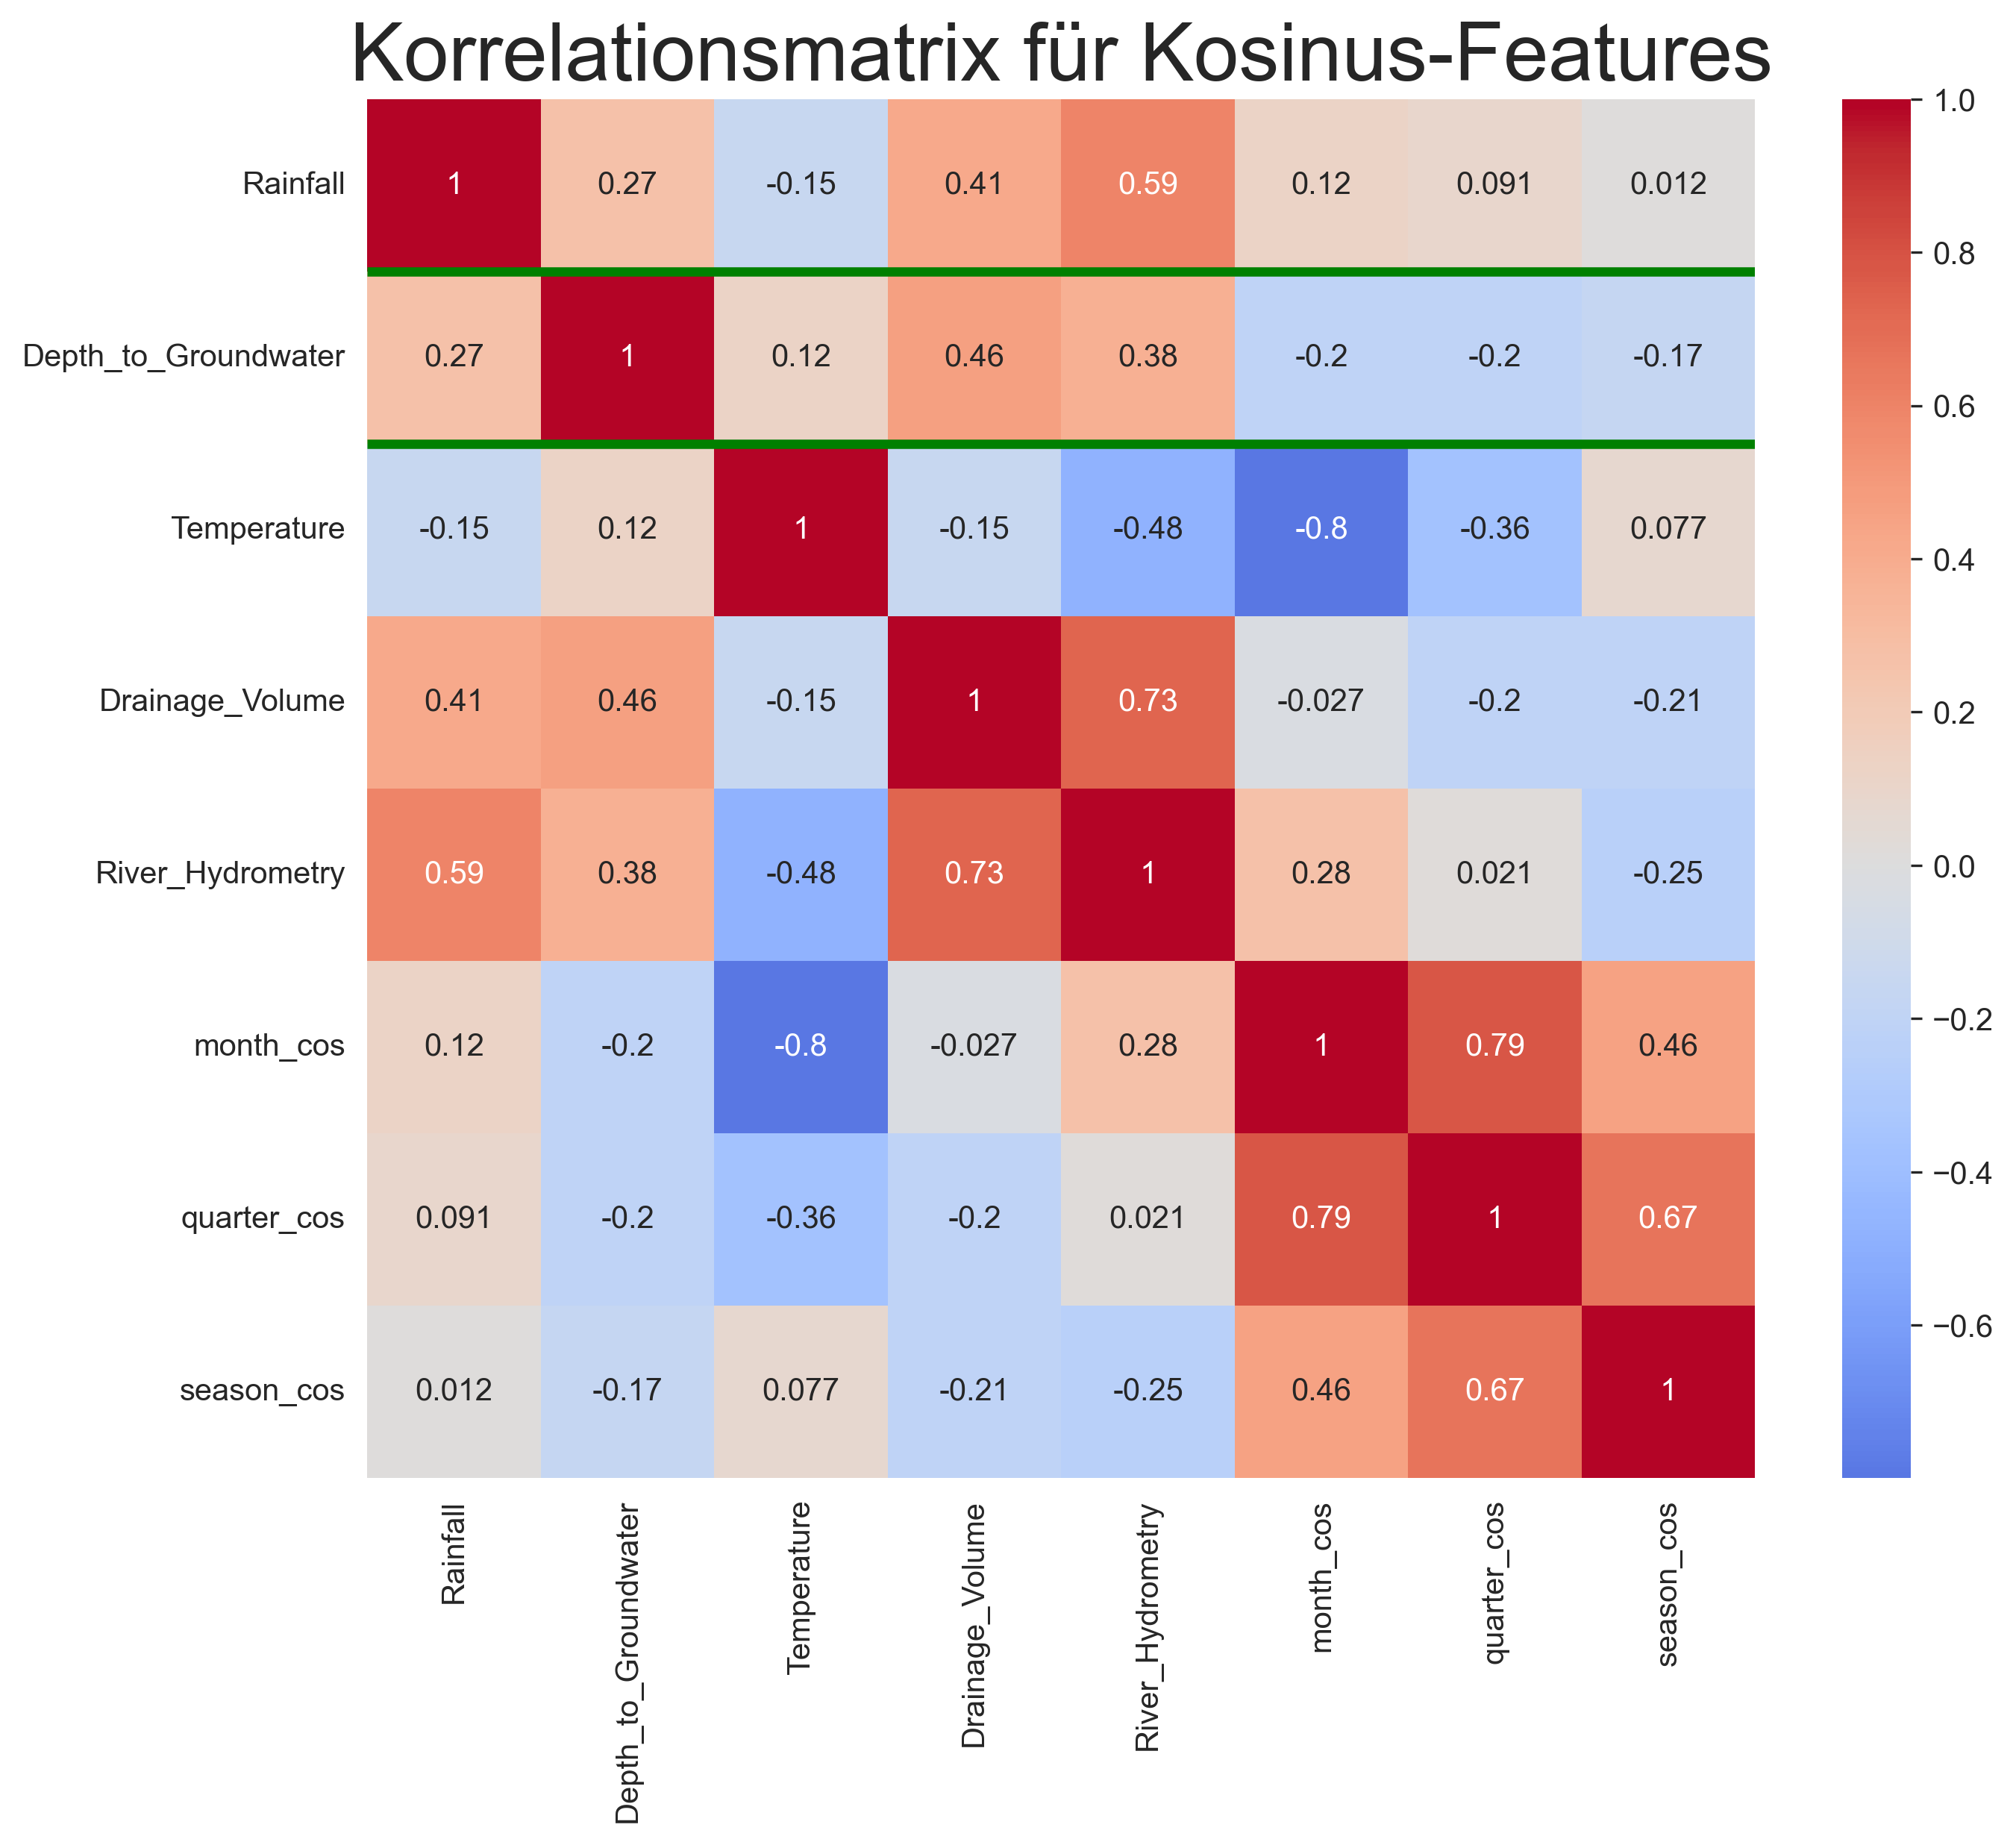

In [70]:
import seaborn as sns
plt.figure(figsize=(10, 8),dpi=300)  # Adjust the figsize as needed
plt.tight_layout()
matrix1 = df_cos.corr()
ax = sns.heatmap(matrix1, cmap='coolwarm', annot=True, center=0)
ax.set_title('Korrelationsmatrix für Kosinus-Features', fontsize=26)
highlighted_row_index = 1  # Ändere dies entsprechend der gewünschten Zeile
ax.hlines(highlighted_row_index, *ax.get_xlim(), colors='green', linewidth=3)
ax.hlines(highlighted_row_index+1, *ax.get_xlim(), colors='green', linewidth=3)
#plt.savefig('graphs/corr.png', format='png', transparent=True, bbox_inches='tight')
plt.show()

In [110]:
features_3 = ['Rainfall', 'Depth_to_Groundwater', 'Drainage_Volume', 'River_Hydrometry', 'month_cos', 'quarter_cos']
features_new = ['Depth_to_Groundwater', 'Drainage_Volume', 'River_Hydrometry', 'month_cos', 'week_of_year_cos', 'quarter_cos']
delete3 = [feature for feature in df_cos.columns if feature not in features_new]
df_new = df_cos.drop(delete3, axis=1)

In [111]:
df = df_new
df

,Depth_to_Groundwater,Drainage_Volume,River_Hydrometry,month_cos,week_of_year_cos,quarter_cos
Date,,,,,,
2009-01-01,0.175907,0.672018,0.260870,0.866025,0.992749,6.123234e-17
2009-01-02,0.177960,0.507291,0.304348,0.866025,0.992749,6.123234e-17
2009-01-03,0.180698,0.624189,0.260870,0.866025,0.992749,6.123234e-17
2009-01-04,0.182067,0.540839,0.260870,0.866025,0.992749,6.123234e-17
2009-01-05,0.184805,0.465917,0.217391,0.866025,0.971100,6.123234e-17
...,...,...,...,...,...,...
2020-06-26,0.591376,0.462974,0.304348,-1.000000,-0.999963,-1.000000e+00
2020-06-27,0.588638,0.408690,0.260870,-1.000000,-0.999963,-1.000000e+00
2020-06-28,0.583162,0.378186,0.260870,-1.000000,-0.999963,-1.000000e+00


In [32]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
from tensorboard.plugins.hparams import api as hp

In [98]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 96, 128]))
HP_N_STEPS_IN = hp.HParam('n_steps_in', hp.Discrete([3, 5, 7, 10, 15]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.3, 0.4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'nadam']))

METRIC_RMSE = 'RootMeanSquaredError'

logdir = 'logs/hparam_tuning_multi'
with tf.summary.create_file_writer(logdir).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_N_STEPS_IN, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')]
    )


In [99]:
N_FEATURES  = 6  # multivariate
#N_STEPS_IN  = 5 # static window
N_STEPS_OUT = 1  # single-step

In [100]:
def df_to_X_y(df, hparams):
    N_STEPS_IN  = hparams[HP_N_STEPS_IN]
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - N_STEPS_IN):
        row = [r for r in df_as_np[i:i + N_STEPS_IN]]
        X.append(row)
        label = df_as_np[i + N_STEPS_IN][0]
        y.append(label)
    return np.array(X), np.array(y)

def get_sets(df, hparams):
    X1, y1 = df_to_X_y(df, hparams)
    N_STEPS_IN  = hparams[HP_N_STEPS_IN]
    TRAIN_SIZE = int((len(df.index)-N_STEPS_IN) * 0.5)
    VAL_SIZE = int((len(df.index)-N_STEPS_IN) * 0.2)

    X_train1, y_train1 = X1[:TRAIN_SIZE], y1[:TRAIN_SIZE]
    X_val1, y_val1 = X1[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE], y1[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE]
    X_test1, y_test1 = X1[TRAIN_SIZE + VAL_SIZE:], y1[TRAIN_SIZE + VAL_SIZE:]
    return X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1

In [101]:
def init_model(hparams):
    # Use initializers to initialize model parameters with the same values
    INITIALIZER_GLOROT_UNIFORM = tf.keras.initializers.GlorotUniform(seed=SEED)
    INITIALIZER_ORTHOGONAL = tf.keras.initializers.Orthogonal(gain=1.0, seed=SEED)
    model = Sequential()
    model.add(InputLayer((hparams[HP_N_STEPS_IN], N_FEATURES)))
    model.add(SimpleRNN(units=hparams[HP_NUM_UNITS],
                   kernel_initializer=INITIALIZER_GLOROT_UNIFORM,
                   recurrent_initializer=INITIALIZER_ORTHOGONAL))
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    model.add(Dense(units=8, activation='relu', kernel_initializer=INITIALIZER_GLOROT_UNIFORM))
    model.add(Dense(units=N_STEPS_OUT,
                    kernel_initializer=INITIALIZER_GLOROT_UNIFORM,
                    activation='linear'))
    return model

In [102]:
def train_model(df, hparams):
    X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = get_sets(df, hparams)
    model = init_model(hparams)
    model.compile(loss=MeanSquaredError(), optimizer=hparams[HP_OPTIMIZER], metrics=[RootMeanSquaredError()])
    model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=15, verbose=0, callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams),  # log hparams
    ])
    return model

In [103]:
def train_test_model(df, hparams):
    X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = get_sets(df, hparams)
    model = train_model(df, hparams)
    _, rmse = model.evaluate(X_test1, y_test1)
    return  rmse

In [104]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(df, hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=10)

In [112]:
session_num = 0
for n_steps_in in HP_N_STEPS_IN.domain.values:
    for num_units in HP_NUM_UNITS.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for optimizer in HP_OPTIMIZER.domain.values:
                hparams = {
                    HP_N_STEPS_IN: n_steps_in,
                    HP_NUM_UNITS: num_units,
                    HP_DROPOUT: dropout_rate,
                    HP_OPTIMIZER: optimizer,
                }
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run('logs/rnn/hparam_tuning_1/' + run_name, hparams)
                session_num += 1


--- Starting trial: run-0
{'n_steps_in': 3, 'num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'}
40/40 [==============================] - 0s 1ms/step - loss: 2.3762e-04 - root_mean_squared_error: 0.0154
--- Starting trial: run-1
{'n_steps_in': 3, 'num_units': 64, 'dropout': 0.1, 'optimizer': 'nadam'}
40/40 [==============================] - 0s 1ms/step - loss: 1.9435e-04 - root_mean_squared_error: 0.0139
--- Starting trial: run-2
{'n_steps_in': 3, 'num_units': 64, 'dropout': 0.2, 'optimizer': 'adam'}
40/40 [==============================] - 0s 2ms/step - loss: 2.3762e-04 - root_mean_squared_error: 0.0154
--- Starting trial: run-3
{'n_steps_in': 3, 'num_units': 64, 'dropout': 0.2, 'optimizer': 'nadam'}
40/40 [==============================] - 0s 1ms/step - loss: 1.9435e-04 - root_mean_squared_error: 0.0139
--- Starting trial: run-4
{'n_steps_in': 3, 'num_units': 64, 'dropout': 0.3, 'optimizer': 'adam'}
40/40 [==============================] - 0s 1ms/step - loss: 2.3762e-04 - root_mean_

In [113]:
%tensorboard --logdir logs/rnn/hparam_tuning_2/ --port 6008

Launching TensorBoard...

In [114]:
import winsound
winsound.Beep(2500,1000)